# EDA

In [10]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt 
import numpy as np
from sklearn.feature_selection import mutual_info_classif, chi2, f_classif
import itertools

from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, RepeatedStratifiedKFold
from sklearn.pipeline import Pipeline 
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.neighbors import KNeighborsClassifier, NeighborhoodComponentsAnalysis 
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, make_scorer

import matplotlib.pyplot as plt

In [4]:
df=pd.read_csv("../data/raw.csv")

In [5]:
features = list(df.columns)[1:]

In [6]:
df.corr()

,Y,X1,X2,X3,X4,X5,X6
Y,1.000000,0.280160,-0.024274,0.150838,0.064415,0.224522,0.167669
X1,0.280160,1.000000,0.059797,0.283358,0.087541,0.432772,0.411873
X2,-0.024274,0.059797,1.000000,0.184129,0.114838,0.039996,-0.062205
X3,0.150838,0.283358,0.184129,1.000000,0.302618,0.358397,0.203750
X4,0.064415,0.087541,0.114838,0.302618,1.000000,0.293115,0.215888
X5,0.224522,0.432772,0.039996,0.358397,0.293115,1.000000,0.320195
X6,0.167669,0.411873,-0.062205,0.203750,0.215888,0.320195,1.000000


In [7]:
df_corr=pd.DataFrame({"features":features, "corr":df.corr()["Y"].iloc[1:].values}).sort_values("corr",ascending=False)
df_corr

,features,corr
0,X1,0.280160
4,X5,0.224522
5,X6,0.167669
2,X3,0.150838
3,X4,0.064415
1,X2,-0.024274


In [8]:
mi=mutual_info_classif(X=df[features],y=df["Y"],discrete_features=True)
df_mi=pd.DataFrame({"features":features,"mi":mi}).sort_values(by=["mi"], ascending=False)
df_mi

,features,mi
0,X1,0.049705
5,X6,0.035543
4,X5,0.027627
3,X4,0.021880
2,X3,0.017432
1,X2,0.009468


In [11]:
F_scores, p_values=f_classif(X=df[features],y=df["Y"])
df_F=pd.DataFrame({"features":features, "F Score":F_scores, "p values": p_values}).sort_values(by=["F Score"], ascending=False)
df_F

,features,F Score,p values
0,X1,10.561708,0.001486
4,X5,6.582716,0.011488
5,X6,3.586849,0.060568
2,X3,2.886959,0.091807
3,X4,0.516657,0.473623
1,X2,0.073108,0.787313


No two have correlation too high. So there is nothing that I "clearly have to make a choice between". 

In [24]:
agg_dict={feat:["mean","std"] for feat in features}

In [25]:
df[features].agg(agg_dict)

,X1,X2,X3,X4,X5,X6
mean,4.333333,2.531746,3.309524,3.746032,3.650794,4.253968
std,0.800000,1.114892,1.023440,0.875776,1.147641,0.809311


Normally high variance is more helpful with classifications, just here to get an idea. 

In [26]:
df.groupby(["Y"]).agg(agg_dict)

X1                  X2                  X3                  X4  \
       mean       std      mean       std      mean       std      mean   
Y                                                                         
0  4.087719  0.851064  2.561404  1.134170  3.140351  1.007802  3.684211   
1  4.536232  0.698311  2.507246  1.106441  3.449275  1.022342  3.797101   

                   X5                  X6            
        std      mean       std      mean       std  
Y                                                    
0  0.848484  3.368421  1.189712  4.105263  0.838455  
1  0.900649  3.884058  1.064621  4.376812  0.768908

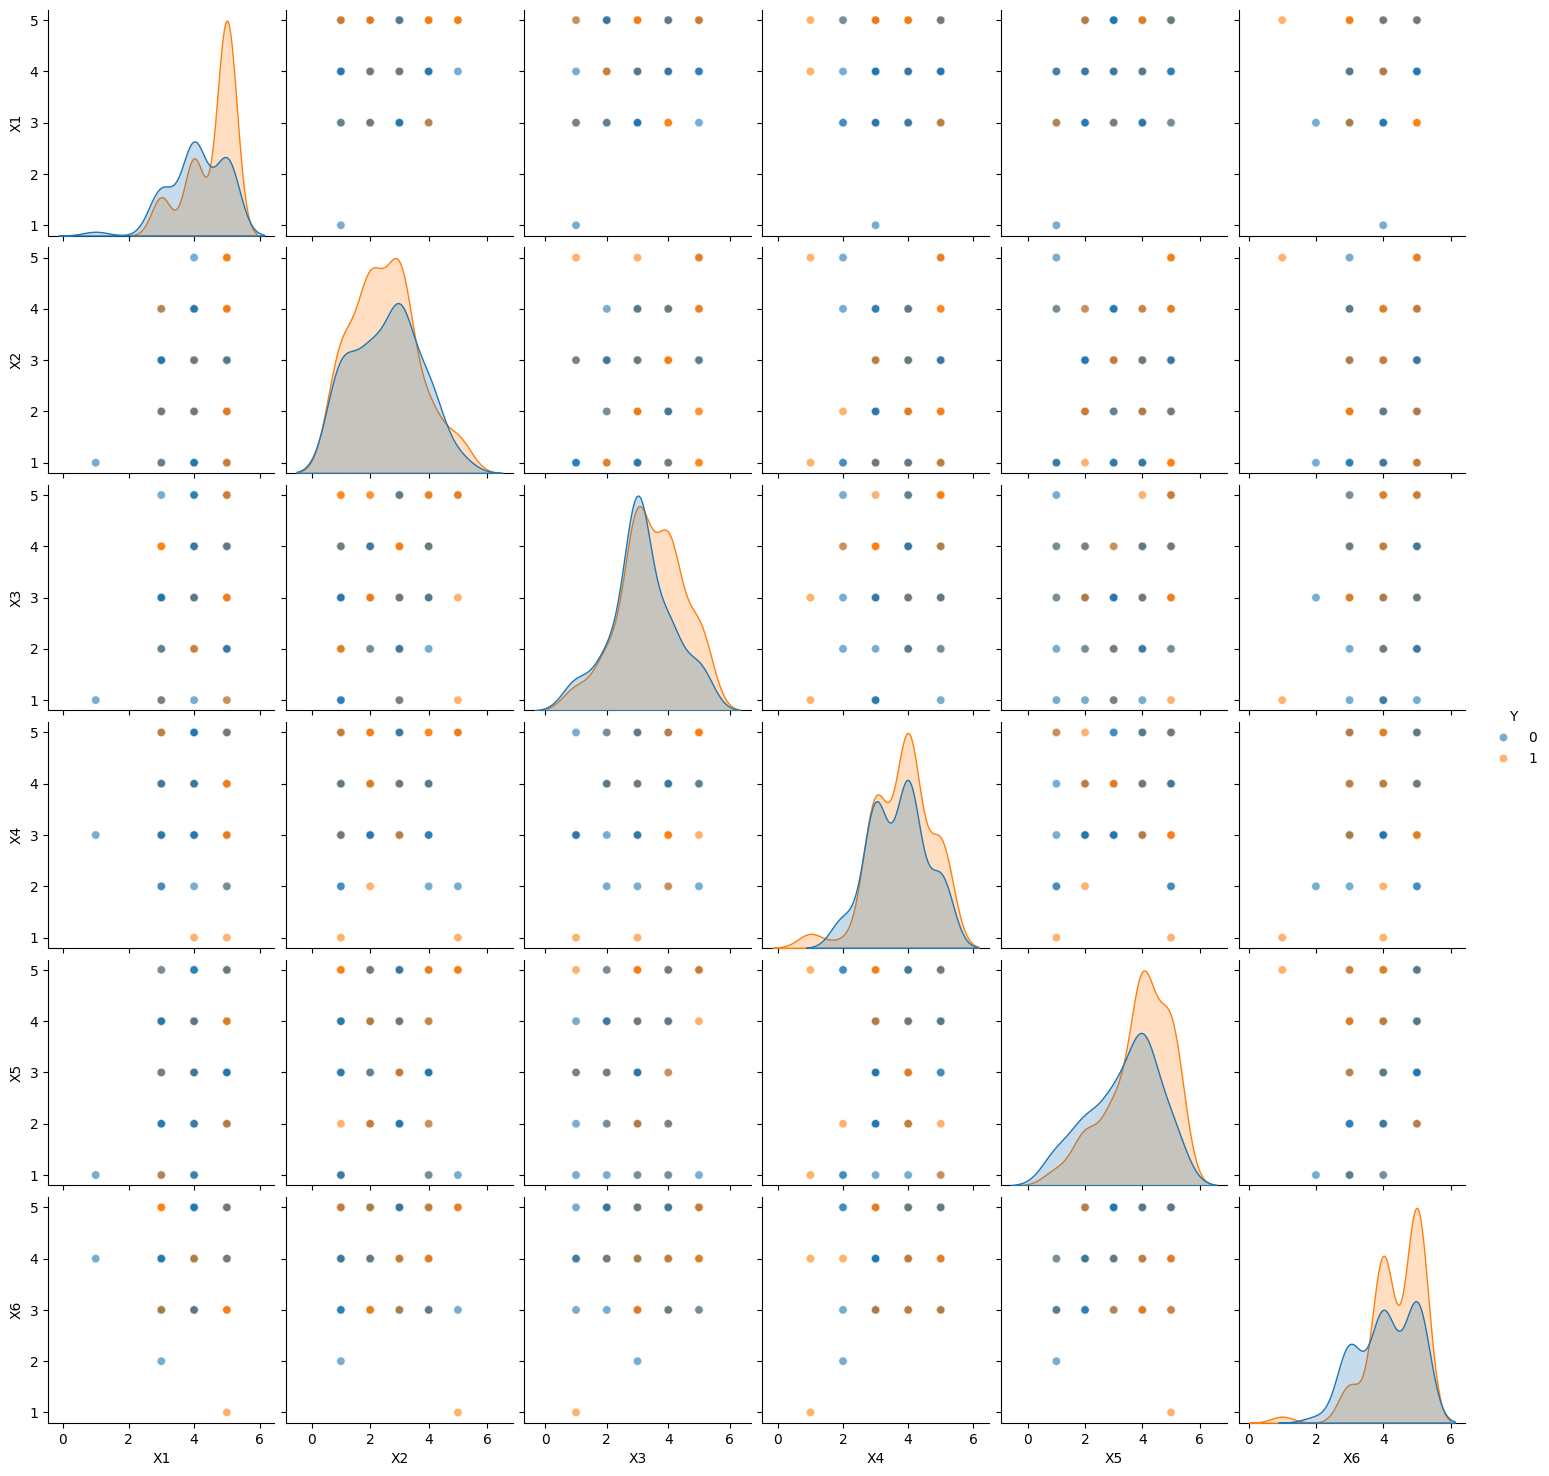

In [27]:
sns.pairplot(data = df,
                x_vars = features,
                y_vars = features,
                hue = "Y",
                plot_kws = {'alpha':.6})

plt.show()

It is hard to see what is going on with the interaction term boundaries (the features are discrete), but the histograms does show some features have distinct distributions when grouped by Y's value. In particular, the feature values are clearly discrete, this might make methods of "boundary drawing", like SVM less appropriate. 

In [28]:
len(df)

126

There are only 126 data points, since there is a hidden public test set online, I will opt for not cut out a segregated test set (only using training and validation sets) to try to use as much data I can on training. 

In [29]:
len(df[df["Y"]==1])

69

In [1]:
69/126

0.5476190476190477

The data set is not very imbalanced, f1 score would not be as useful (I might use it as a secondary fine-tuning option). Accuracy score alone should be good enough. 

Let's imagine if we were the customer, and if we ranked 5 on all things, it is most likely that I am quite happy. 
So it is not only above each of these features, it is also about all the features together. Let's find a way to reflect that. 
Some of them mater more, according to chi2 and mutual info, so we can try weighting the mean as well. 

In [12]:
df_F

,features,F Score,p values
0,X1,10.561708,0.001486
4,X5,6.582716,0.011488
5,X6,3.586849,0.060568
2,X3,2.886959,0.091807
3,X4,0.516657,0.473623
1,X2,0.073108,0.787313


In [33]:
df_mi

,features,mi
0,X1,0.049705
5,X6,0.035543
4,X5,0.027627
3,X4,0.021880
2,X3,0.017432
1,X2,0.009468


In [13]:
df2=df.copy(deep=True)

df2["mean"]=df2[features].mean(axis=1)
df2["F_w_mean"]=df2[features].apply(lambda row_arr: (np.array(row_arr)* f_classif(X=df2[features],y=df2["Y"])[0]).sum()/len(features), axis=1)
df2["mi_w_mean"]=df2[features].apply(lambda row_arr: (np.array(row_arr)*mutual_info_classif(X=df2[features],y=df2["Y"],discrete_features=True)).sum()/len(features), axis=1)
df2["above_3"]=df2[features].apply(lambda row_arr: (row_arr >= 3).sum()/len(features), axis=1)
df2["above_4"]=df2[features].apply(lambda row_arr: (row_arr >= 4).sum()/len(features), axis=1)
df2["above_5"]=df2[features].apply(lambda row_arr: (row_arr >= 5).sum()/len(features), axis=1)
df2

,Y,X1,X2,X3,X4,X5,X6,mean,F_w_mean,mi_w_mean,above_3,above_4,above_5
0,0,3,3,3,4,2,4,3.166667,11.690798,0.085794,0.833333,0.333333,0.000000
1,0,3,2,3,5,4,3,3.333333,13.361153,0.091148,0.833333,0.333333,0.166667
2,1,5,3,3,3,3,5,3.666667,16.820185,0.109244,1.000000,0.333333,0.333333
3,0,5,4,3,3,3,5,3.833333,16.832370,0.110822,1.000000,0.500000,0.333333
4,0,5,4,3,3,3,5,3.833333,16.832370,0.110822,1.000000,0.500000,0.333333
...,...,...,...,...,...,...,...,...,...,...,...,...,...
121,1,5,2,3,4,4,3,3.500000,16.795613,0.104069,0.833333,0.500000,0.166667
122,1,5,2,3,4,2,5,3.500000,15.796991,0.106708,0.666667,0.500000,0.333333
123,1,5,3,3,4,4,5,4.000000,18.003414,0.117495,1.000000,0.666667,0.333333
124,0,4,3,3,4,4,5,3.833333,16.243130,0.109211,1.000000,0.666667,0.166667


In [18]:
df2_mm=(df2-df2.min())/(df2.max()-df2.min())
df2_mm

,Y,X1,X2,X3,X4,X5,X6,mean,F_w_mean,mi_w_mean,above_3,above_4,above_5
0,0.0,0.50,0.50,0.50,0.75,0.25,0.75,0.421053,0.401501,0.408513,0.75,0.333333,0.000000
1,0.0,0.50,0.25,0.50,1.00,0.75,0.50,0.473684,0.519356,0.473247,0.75,0.333333,0.166667
2,1.0,1.00,0.50,0.50,0.50,0.50,1.00,0.578947,0.763413,0.692051,1.00,0.333333,0.333333
3,0.0,1.00,0.75,0.50,0.50,0.50,1.00,0.631579,0.764273,0.711130,1.00,0.500000,0.333333
4,0.0,1.00,0.75,0.50,0.50,0.50,1.00,0.631579,0.764273,0.711130,1.00,0.500000,0.333333
...,...,...,...,...,...,...,...,...,...,...,...,...,...
121,1.0,1.00,0.25,0.50,0.75,0.75,0.50,0.526316,0.761680,0.629485,0.75,0.500000,0.166667
122,1.0,1.00,0.25,0.50,0.75,0.25,1.00,0.526316,0.691220,0.661391,0.50,0.500000,0.333333
123,1.0,1.00,0.50,0.50,0.75,0.75,1.00,0.684211,0.846898,0.791817,1.00,0.666667,0.333333
124,0.0,0.75,0.50,0.50,0.75,0.75,1.00,0.631579,0.722698,0.691652,1.00,0.666667,0.166667


In [16]:
F_score, p_values = f_classif(X=df2[df2.columns[1:]],y=df2["Y"])

F_df=pd.DataFrame({
    "features": df2.columns[1:],
    "F score": F_score,
    "p value": p_values
}).sort_values(by=["F score"], ascending=False)

F_df

,features,F score,p value
7,F_w_mean,12.615311,0.000542
8,mi_w_mean,10.796944,0.001322
0,X1,10.561708,0.001486
6,mean,7.306094,0.007836
10,above_4,7.194813,0.008308
4,X5,6.582716,0.011488
11,above_5,6.520675,0.011874
5,X6,3.586849,0.060568
2,X3,2.886959,0.091807
9,above_3,1.032794,0.311482


In [17]:
df2.corr()

,Y,X1,X2,X3,X4,X5,X6,mean,F_w_mean,mi_w_mean,above_3,above_4,above_5
Y,1.000000,0.280160,-0.024274,0.150838,0.064415,0.224522,0.167669,0.235885,0.303878,0.283016,0.090886,0.234181,0.223515
X1,0.280160,1.000000,0.059797,0.283358,0.087541,0.432772,0.411873,0.607460,0.834641,0.769102,0.266199,0.492355,0.604855
X2,-0.024274,0.059797,1.000000,0.184129,0.114838,0.039996,-0.062205,0.426097,0.078909,0.189348,0.500598,0.268810,0.215269
X3,0.150838,0.283358,0.184129,1.000000,0.302618,0.358397,0.203750,0.676149,0.532371,0.572085,0.442280,0.638649,0.481689
X4,0.064415,0.087541,0.114838,0.302618,1.000000,0.293115,0.215888,0.557803,0.298662,0.473518,0.383442,0.521454,0.389949
X5,0.224522,0.432772,0.039996,0.358397,0.293115,1.000000,0.320195,0.712786,0.806779,0.746472,0.491804,0.616787,0.586695
X6,0.167669,0.411873,-0.062205,0.203750,0.215888,0.320195,1.000000,0.540096,0.574523,0.660277,0.261704,0.458477,0.490605
mean,0.235885,0.607460,0.426097,0.676149,0.557803,0.712786,0.540096,1.000000,0.869373,0.947293,0.687659,0.848710,0.773920
F_w_mean,0.303878,0.834641,0.078909,0.532371,0.298662,0.806779,0.574523,0.869373,1.000000,0.966426,0.498831,0.743851,0.761327
mi_w_mean,0.283016,0.769102,0.189348,0.572085,0.473518,0.746472,0.660277,0.947293,0.966426,1.000000,0.573713,0.809818,0.794565


Some quick models

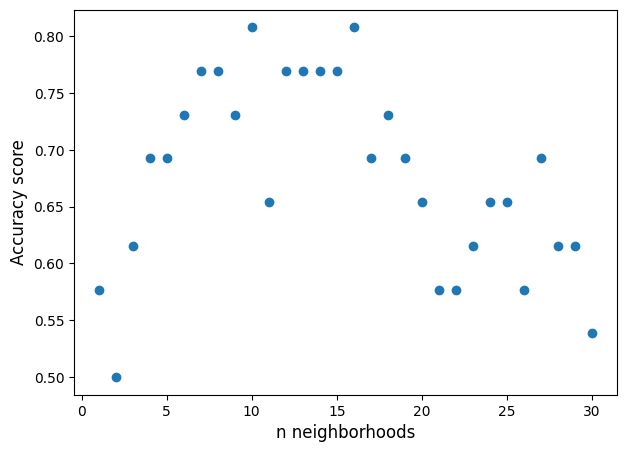

0.8076923076923077
10


In [19]:
features=["F_w_mean","above_4","above_5","X5","X6","X3"] # Manually chose 6 that ranked high on chi2 and did not have high corr with each other. 
target=["Y"]
feat=df2[features] # Do not use df2_mm here, that would be data leakage. 
tar=df2[target] # Do not use df2_mm here, that would be data leakage. 
x_t, x_v, y_t, y_v= train_test_split(feat,tar, test_size=0.2, random_state=0, stratify=tar["Y"])

y_t=np.ravel(y_t.values)
y_v=np.ravel(y_v.values)

list_acc=[]
for n in range(1,30+1): 
    NCA_KNN_pipe=Pipeline([("scale",StandardScaler()),("KNN",KNeighborsClassifier(n_neighbors=n))]) 
    NCA_KNN_pipe.fit(X=x_t,y=y_t)
    y_p=NCA_KNN_pipe.predict(X=x_v)
    acc=accuracy_score(y_pred=y_p,y_true=y_v)
    list_acc.append(acc)
    # print(acc)

plt.figure(figsize=(7,5))

plt.scatter(range(1,30+1),list_acc)

plt.xlabel("n neighborhoods",fontsize=12)
plt.ylabel("Accuracy score",fontsize=12)

plt.show()

print(max(list_acc))

print(list_acc.index(max(list_acc))+1)

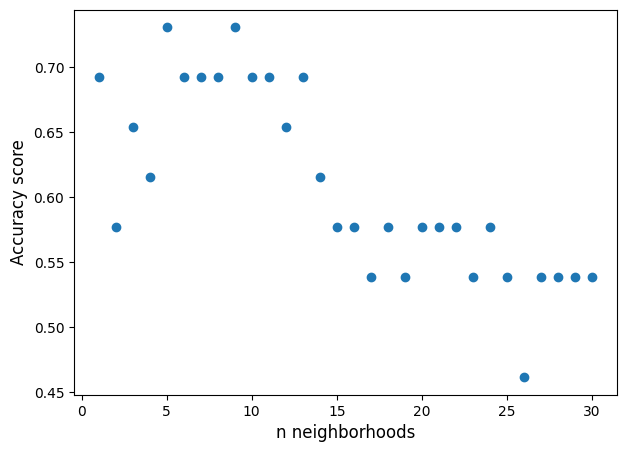

0.7307692307692307


In [20]:
list_acc=[]
for n in range(1,30+1): 
    NCA_KNN_pipe=Pipeline([("scale",StandardScaler()),("NCA", NeighborhoodComponentsAnalysis()),("KNN",KNeighborsClassifier(n_neighbors=n))]) 
    NCA_KNN_pipe.fit(X=x_t,y=y_t)
    y_p=NCA_KNN_pipe.predict(X=x_v)
    acc=accuracy_score(y_pred=y_p,y_true=y_v)
    list_acc.append(acc)
    
plt.figure(figsize=(7,5))

plt.scatter(range(1,30+1),list_acc)

plt.xlabel("n neighborhoods",fontsize=12)
plt.ylabel("Accuracy score",fontsize=12)

plt.show()

print(max(list_acc))

In [21]:
list_acc.index(max(list_acc))+1

5

I am surprised. Planning on showing this with cross validation, and make the process automated. But before that, let's see if this model is as powerful as we might hope. 

In [22]:
list_fold_acc=[]

RSKF=RepeatedStratifiedKFold(n_splits=5,random_state=420,n_repeats=100)

for train_index, test_index in RSKF.split(X=feat,y=tar): 
    x_tr,x_te=feat.iloc[train_index], feat.iloc[test_index]
    y_tr, y_te=tar.iloc[train_index], tar.iloc[test_index]
    
    y_tr=np.ravel(y_tr.values)
    y_te=np.ravel((y_te.values))
    
    NCA_KNN_pipe=Pipeline([("scale",StandardScaler()),("NCA", NeighborhoodComponentsAnalysis()),("KNN",KNeighborsClassifier(n_neighbors=5))])
    NCA_KNN_pipe.fit(X=x_tr,y=y_tr)
    y_p=NCA_KNN_pipe.predict(X=x_te)
    acc=accuracy_score(y_pred=y_p,y_true=y_te)
    list_fold_acc.append(acc)
    
# print(list_fold_acc)

print(np.mean(list_fold_acc))
print(np.std(list_fold_acc))

0.6222553846153847
0.08910799038411683


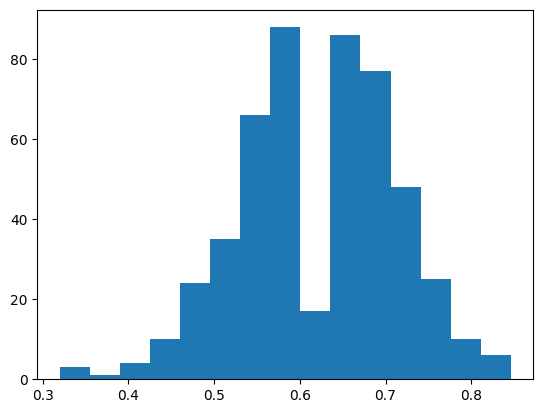

In [23]:
plt.hist(list_fold_acc,bins=15)
plt.show()

In [24]:
above_73=(np.array(list_fold_acc)>=0.73).sum()/500
above_73

np.float64(0.108)

Not as powerful as we hoped. Only 11% sure it can beat the 73% line. 

In [25]:
list_fold_acc=[]

RSKF=RepeatedStratifiedKFold(n_splits=5,random_state=420,n_repeats=100)

for train_index, test_index in RSKF.split(X=feat,y=tar): 
    x_tr,x_te=feat.iloc[train_index], feat.iloc[test_index]
    y_tr, y_te=tar.iloc[train_index], tar.iloc[test_index]
    
    y_tr=np.ravel(y_tr.values)
    y_te=np.ravel((y_te.values))
    
    NCA_KNN_pipe=Pipeline([("scale",StandardScaler()),("KNN",KNeighborsClassifier(n_neighbors=10))])
    NCA_KNN_pipe.fit(X=x_tr,y=y_tr)
    y_p=NCA_KNN_pipe.predict(X=x_te)
    acc=accuracy_score(y_pred=y_p,y_true=y_te)
    list_fold_acc.append(acc)
    
# print(list_fold_acc)

print(np.mean(list_fold_acc))
print(np.std(list_fold_acc))

0.6361076923076924
0.08720481366660454


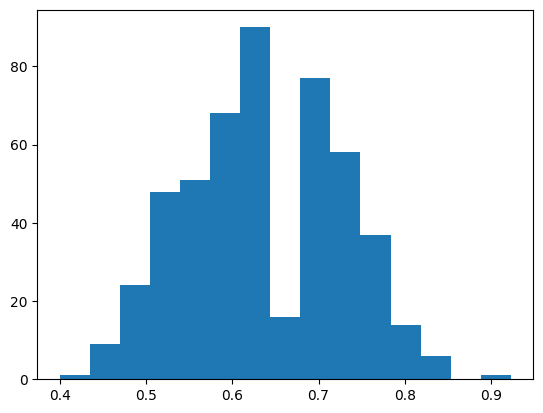

In [26]:
plt.hist(list_fold_acc,bins=15)
plt.show()

In [27]:
above_73=(np.array(list_fold_acc)>=0.73).sum()/500
above_73

np.float64(0.132)

But compare to the no NCA version, the NCA version does worse. 

The goal is to do something like the following, the point is not how high I could get it: I could get it as high as around 0.9, but that only happened by luck. The point is how sure I could beat a certain line (73 percent in our case), and that should be the real metric of this problem. 

In [28]:
range_nc=range(1,6+1)
range_nn=range(1,15+1)

n_split=5
n_repeats=20

list_nc=[]
list_nn=[]
list_acc_mean=[]
list_acc_std=[]
list_above_73=[]

RSKF=RepeatedStratifiedKFold(n_splits=n_split,random_state=420,n_repeats=n_repeats)

for nc,nn in itertools.product(range_nc,range_nn): 
    list_fold_acc=[]
    for train_index, test_index in RSKF.split(X=feat,y=tar): 
        x_tr,x_te=feat.iloc[train_index], feat.iloc[test_index]
        y_tr, y_te=tar.iloc[train_index], tar.iloc[test_index]
        
        y_tr=np.ravel(y_tr.values)
        y_te=np.ravel((y_te.values))
        
        NCA_KNN_pipe=Pipeline([("scale",StandardScaler()),("NCA",NeighborhoodComponentsAnalysis(n_components=nc)),("KNN",KNeighborsClassifier(n_neighbors=nn))])
        NCA_KNN_pipe.fit(X=x_tr,y=y_tr)
        y_p=NCA_KNN_pipe.predict(X=x_te)
        acc=accuracy_score(y_pred=y_p,y_true=y_te)
        list_fold_acc.append(acc)
    list_nc.append(nc)
    list_nn.append(nn)
    list_acc_mean.append(np.mean(list_fold_acc))
    list_acc_std.append(np.std(list_fold_acc))
    list_above_73.append((np.array(list_fold_acc)>=0.73).sum()/(n_split*n_repeats))
    print(f"Test for {nc} components and {nn} neighbors concluded with acc mean {np.mean(list_fold_acc)} acc std {np.std(list_fold_acc)} and sureness of beating 73% {(np.array(list_fold_acc)>=0.73).sum()/(n_split*n_repeats)}.")

Test for 1 components and 1 neighbors concluded with acc mean 0.5812307692307692 acc std 0.09783333249330496 and sureness of beating 73% 0.03.
Test for 1 components and 2 neighbors concluded with acc mean 0.5725076923076922 acc std 0.10818910794032398 and sureness of beating 73% 0.04.
Test for 1 components and 3 neighbors concluded with acc mean 0.6001384615384615 acc std 0.10558848220314797 and sureness of beating 73% 0.08.
Test for 1 components and 4 neighbors concluded with acc mean 0.5706461538461539 acc std 0.10726126483922908 and sureness of beating 73% 0.06.
Test for 1 components and 5 neighbors concluded with acc mean 0.5906307692307693 acc std 0.09549995383994671 and sureness of beating 73% 0.05.
Test for 1 components and 6 neighbors concluded with acc mean 0.5702923076923078 acc std 0.09700477509139716 and sureness of beating 73% 0.03.
Test for 1 components and 7 neighbors concluded with acc mean 0.5904 acc std 0.09352811683688095 and sureness of beating 73% 0.05.
Test for 1 

In [29]:
df_nca_knn_record=pd.DataFrame({"n component":list_nc, "n neighborhood":list_nn, "acc mean": list_acc_mean, "acc std":list_acc_std, "above 73":list_above_73})

In [30]:
df_nca_knn_record.sort_values(by=["above 73", "acc mean"], ascending=False).reset_index(drop=True)

,n component,n neighborhood,acc mean,acc std,above 73
0,3,5,0.632785,0.090320,0.13
1,3,10,0.623785,0.098897,0.13
2,5,7,0.610954,0.096055,0.13
3,6,10,0.606092,0.103838,0.13
4,4,5,0.623262,0.091746,0.12
...,...,...,...,...,...
85,1,6,0.570292,0.097005,0.03
86,5,1,0.596000,0.075939,0.02
87,5,2,0.573631,0.077508,0.02
88,6,2,0.570723,0.092680,0.02


Above says: The best model has 18.4% sureness of beating 73% accuracy, with accuracy mean of 0.6513 and std of 0.0872. Let's retrain it and graph it: 

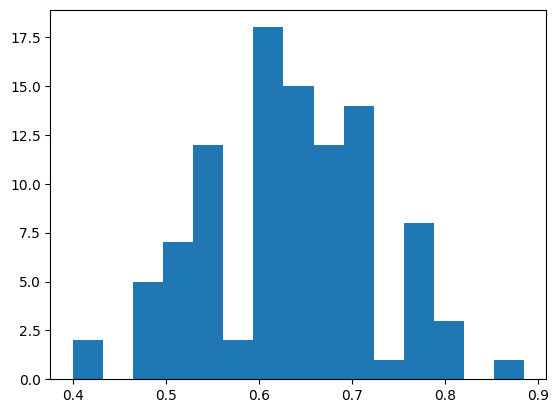

In [31]:
list_fold_acc=[]
for train_index, test_index in RSKF.split(X=feat,y=tar): 
        x_tr,x_te=feat.iloc[train_index], feat.iloc[test_index]
        y_tr, y_te=tar.iloc[train_index], tar.iloc[test_index]
        
        y_tr=np.ravel(y_tr.values)
        y_te=np.ravel((y_te.values))
        
        NCA_KNN_pipe=Pipeline([("scale",StandardScaler()),("NCA",NeighborhoodComponentsAnalysis(n_components=3)),("KNN",KNeighborsClassifier(n_neighbors=5))])
        NCA_KNN_pipe.fit(X=x_tr,y=y_tr)
        y_p=NCA_KNN_pipe.predict(X=x_te)
        acc=accuracy_score(y_pred=y_p,y_true=y_te)
        list_fold_acc.append(acc)
        
plt.hist(list_fold_acc,bins=15)
plt.show()

In [32]:
(np.array(list_fold_acc)>=0.73).sum()/(n_split*n_repeats)

np.float64(0.13)

In [33]:
0.6513/(69/126) - 1

0.18933043478260858

This model, on average, beat the baseline 0.54 by 19%. 

Above is a little taste of what I am planning, we will break into different notebooks for each type of model from this point on.  